In [3]:
# import libraries
%matplotlib inline
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import matplotlib.pyplot as plt
import re
import sklearn
from sklearn.model_selection import train_test_split 

In [4]:
data = pd.read_csv('C:/Users/LENOVO/Documents/Tweets.csv', sep=',')
data.shape
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


Text(0.5, 1.0, 'Sentiment v Sentiment count ')

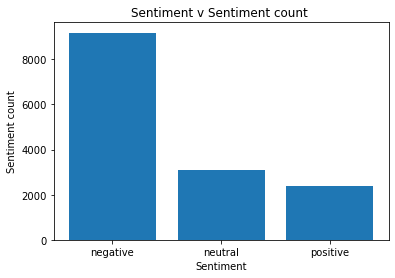

In [5]:
# Plot sentiments v.s sentiment count
sentiment_count = data['airline_sentiment'].value_counts()
print(sentiment_count) 
plt.bar([1,2,3], sentiment_count)
plt.xticks([1,2,3], ['negative', 'neutral', 'positive'])
plt.ylabel('Sentiment count')
plt.xlabel('Sentiment')
plt.title('Sentiment v Sentiment count ')

In [6]:
# A subset of techniques for tweet pre-processing

def removeUnicode(text):
    """ Removes unicode strings like "\u002c" and "x96" """
    text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)       
    text = re.sub(r'[^\x00-\x7f]',r'',text)
    return text

def replaceAtUser(text):
    """ Replaces "@user" with "atUser" """
    text = re.sub('@[^\s]+','atUser',text)
    return text

def removeHashtagInFrontOfWord(text):
    """ Removes hastag in front of a word """
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

def removeEmoticons(text):
    """ Removes emoticons from text """
    text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)
    return text

""" Replaces contractions from a string to their equivalents """
contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'cannot'), (r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
                         (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not') ]
def replaceContraction(text):
    patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text)
    return text


def lowercase(text):
    """ Make all characters lowercase """
    return text.lower()

In [7]:
# Pre-processing techniques applied sequentially
data.text = data.text.apply(removeUnicode)
data.text = data.text.apply(lowercase)
data.text = data.text.apply(replaceAtUser)
data.text = data.text.apply(removeHashtagInFrontOfWord)
data.text = data.text.apply(replaceContraction)
data.text = data.text.apply(removeEmoticons)

In [8]:
# Create new dataframe
df = pd.DataFrame(data,columns=['airline_sentiment', 'text'])
df = df.rename(columns={'airline_sentiment':'labels'})
df.head()

,labels,text
0,neutral,atUser what atUser said.
1,positive,atUser plus you have added commercials to the ...
2,neutral,atUser i did not today... must mean i need to ...
3,negative,atUser it is really aggressive to blast obnoxi...
4,negative,atUser and it is a really big bad thing about it


In [9]:
# data for classification model
df1 = df[['labels', 'text']]
train, valid = train_test_split(df1,stratify=df['labels'],test_size = 0.1, random_state=43)

# data for language model 
col_names = ['label', 'text']
df_lm = pd.DataFrame({'text': df['text'], 'label': [0]*len(df['text'])}, columns=col_names)
    
train_lm, valid_lm = train_test_split(df_lm,test_size = 0.1, random_state=43)

In [10]:
# Implementing ULMFit
# language model 
data_lm = TextLMDataBunch.from_df(train_df = train_lm, valid_df = valid_lm, path="")

# classification model 
data_class = TextClasDataBunch.from_df(path="", train_df = train, valid_df = valid, vocab=data_lm.train_ds.vocab, bs=32 )

In [11]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

In [12]:
learn.fit_one_cycle(1, 1e-2)


epoch,train_loss,valid_loss,accuracy,time
0,5.107862,4.292661,0.258231,07:27


In [13]:
learn.freeze_to(-1)
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.329115,4.079153,0.277762,07:22


In [14]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.080541,3.926244,0.292160,07:42


In [15]:
# unfreeze all layers
learn.unfreeze()
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.990406,3.881510,0.296763,12:56


In [16]:
learn.save_encoder('tweet_lm')

In [17]:
# classifier model
learn_c = text_classifier_learner(data_class, arch=AWD_LSTM, drop_mult=0.5)
learn_c.load_encoder('tweet_lm')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (13176 items)
x: TextList
xxbos atuser on flight 622 from nassau to jfk . not showing cancelled flightled yet but assuming it will be ? any info ?,xxbos atuser hey let flight xxunk to the gate hours late flight and no fate with dozens of kids on board,xxbos atuser your hold music needs 2 be xxunk xxunk have xxunk phone button xxunk xxunk in xxunk wait time would help 2 .,xxbos atuser he overflowed over the armrest and under with legs xxunk . you should refund me i had no choice . xxunk,xxbos atuser thank you for being jetblue and not xxunk or xxunk . blue is my favorite color ! and jet blue makes it better
y: CategoryList
neutral,negative,negative,negative,positive
Path: .;

Valid: LabelList (1464 items)
x: TextList
xxbos atuser as a million miler i have been delayed plenty . never in the amateurish xxunk does it . i would be embarrassed to be xxunk .,xxbos atuser since i am a loyal usair customer i am sure that they will make this u

In [18]:
learn_c.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.626084,0.506362,0.797814,06:42


In [19]:
learn_c.freeze_to(-1)
learn_c.fit_one_cycle(1, slice(5e-3/2., 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.595473,0.494075,0.814208,06:19


In [20]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(1, slice(5e-3/2., 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.588650,0.481527,0.812158,06:30


In [21]:
learn_c.unfreeze()
learn_c.fit_one_cycle(1, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.515940,0.448488,0.821038,19:33
